In [5]:
import numpy as np
import pandas as pd
import hvplot.pandas
from pathlib import Path
import hvplot

import datetime
from datetime import date, timedelta
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
%matplotlib inline

load_dotenv()

True

In [3]:
def fetch_data():
    """Fetches the latest prices."""
   # Set Alpaca API key and secret

    alpaca_api_key = os.getenv("ALPACA_API_KEY")
    alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
    
    alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")
    today = date.today()
    start = date.today() - timedelta(days=60)

    # Set the tickers & timeframe
    tickers = ["SPY"]

    timeframe = "15Min"

    #Get Closing prices for past 60 days

    df = alpaca.get_barset(
        tickers,
        timeframe,
        start = start,
        end = today
    ).df
    #figure out another way to clean and prep the data here - hard coded for now 
    df_clean = df['SPY']

    # Display sample data
    return df_clean

In [8]:
data = fetch_data()
data = data.reset_index()
data = data.set_index('time', drop=True)
data['close of tomorrow'] = data['close'].shift(-1)
data

,open,high,low,close,volume,close of tomorrow
time,,,,,,
2021-03-16 10:30:00-04:00,397.630,397.830,397.460,397.510,29972,397.450
2021-03-16 10:45:00-04:00,397.470,397.795,397.290,397.450,14948,397.195
2021-03-16 11:00:00-04:00,397.295,397.370,397.015,397.195,30948,397.220
2021-03-16 11:15:00-04:00,397.240,397.460,397.170,397.220,24916,397.000
2021-03-16 11:30:00-04:00,397.320,397.420,396.930,397.000,12524,397.030
...,...,...,...,...,...,...
2021-03-19 14:45:00-04:00,391.035,391.335,390.670,391.325,23458,390.780
2021-03-19 15:00:00-04:00,391.450,391.550,390.775,390.780,35664,390.790
2021-03-19 15:15:00-04:00,390.770,390.920,390.505,390.790,32383,391.025


In [12]:
#define feauture and target values
X = data[['open', 'high', 'low', 'close', 'volume']]
y = data[['close of tomorrow']]


# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [13]:
# Use the MinMaxScaler to scale data between 0 and 1.
scaler = MinMaxScaler()
X_scaler = scaler.fit(X)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
y_scaler = scaler.fit(y)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)

In [14]:
# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

X_train sample values:
[[[0.99113198]
  [0.97080292]
  [1.        ]
  [0.98039216]
  [0.08704605]]

 [[0.97443923]
  [0.96715328]
  [0.98350315]
  [0.97403286]
  [0.02954605]]

 [[0.95618153]
  [0.92283629]
  [0.95681708]
  [0.94700583]
  [0.0907814 ]]] 

X_test sample values:
[[[0.53729786]
  [0.51876955]
  [0.50703542]
  [0.5108638 ]
  [0.1173652 ]]

 [[0.50182577]
  [0.46506778]
  [0.46821931]
  [0.48012719]
  [0.13877078]]

 [[0.48721961]
  [0.46558916]
  [0.41387676]
  [0.33969263]
  [0.35423883]]]


In [15]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [31]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=90, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=45))
model.add(Dropout(dropout_fraction))

# Output layer
model.add(Dense(1))

In [32]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [33]:
# Show the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 5, 30)             3840      
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 30)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 90)             43560     
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 90)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 45)                24480     
_________________________________________________________________
dropout_5 (Dropout)          (None, 45)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [34]:
# Train the model
model.fit(X_train, y_train, epochs=100, shuffle=False, batch_size=90, verbose=1)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.6279
Epoch 2/100
1/1 [==============================] - 0s 12ms/step - loss: 0.5912
Epoch 3/100
1/1 [==============================] - 0s 11ms/step - loss: 0.5521
Epoch 4/100
1/1 [==============================] - 0s 10ms/step - loss: 0.5151
Epoch 5/100
1/1 [==============================] - 0s 11ms/step - loss: 0.4766
Epoch 6/100
1/1 [==============================] - 0s 11ms/step - loss: 0.4386
Epoch 7/100
1/1 [==============================] - 0s 9ms/step - loss: 0.3964
Epoch 8/100
1/1 [==============================] - 0s 10ms/step - loss: 0.3599
Epoch 9/100
1/1 [==============================] - 0s 11ms/step - loss: 0.3162
Epoch 10/100
1/1 [==============================] - 0s 10ms/step - loss: 0.2614
Epoch 11/100
1/1 [==============================] - 0s 10ms/step - loss: 0.2130
Epoch 12/100
1/1 [==============================] - 0s 10ms/step - loss: 0.1668
Epoch 13/100
1/1 [==============================] - 

In [37]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=1)

1/1 [==============================] - 0s 19ms/step - loss: nan


nan

In [38]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [39]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [40]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = data.index[-len(real_prices): ]) 

# Show the DataFrame's head
stocks.tail()

,Actual,Predicted
time,,
2021-03-19 14:45:00-04:00,390.780,393.049316
2021-03-19 15:00:00-04:00,390.790,393.151978
2021-03-19 15:15:00-04:00,391.025,392.889221
2021-03-19 15:30:00-04:00,389.480,392.997925
2021-03-19 15:45:00-04:00,NaN,392.993561


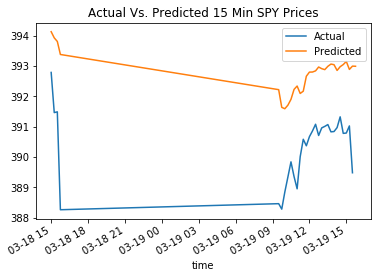

In [41]:
# Plot the real vs predicted prices as a line chart
stocks.plot(title="Actual Vs. Predicted 15 Min SPY Prices")

In [42]:
data2 = data

In [43]:
data2['Predicted'] = stocks['Predicted']

In [47]:
data2.dropna(inplace=True)

In [50]:
data2['Difference'] = abs(data2['close of tomorrow'] - data2['Predicted'])
data2['Avg off'] = data2['Difference'].mean()
data2

,open,high,low,close,volume,close of tomorrow,Predicted,Difference,Avg off
time,,,,,,,,,
2021-03-18 15:00:00-04:00,393.280,393.495,392.380,393.080,37894,392.790,394.133636,1.343636,2.400674
2021-03-18 15:15:00-04:00,392.940,392.980,391.980,392.790,43487,391.465,393.930725,2.465725,2.400674
2021-03-18 15:30:00-04:00,392.800,392.985,391.420,391.465,99786,391.490,393.811584,2.321584,2.400674
2021-03-18 15:45:00-04:00,391.560,391.720,390.920,391.490,173920,388.260,393.381989,5.121989,2.400674
2021-03-19 09:30:00-04:00,389.890,390.165,387.820,388.260,92634,388.460,392.221619,3.761619,2.400674
2021-03-19 09:45:00-04:00,388.170,389.010,387.410,388.460,41544,388.280,391.638123,3.358123,2.400674
2021-03-19 10:00:00-04:00,388.520,388.520,387.155,388.280,36997,388.845,391.591919,2.746919,2.400674
2021-03-19 10:15:00-04:00,388.130,389.120,387.900,388.845,30670,389.340,391.709747,2.369747,2.400674
2021-03-19 10:30:00-04:00,388.860,389.340,387.800,389.340,25175,389.840,391.901550,2.061550,2.400674


In [60]:
#Lets create a new data frame that records if we should buy or sell based the price of tomorrow's close price
#We will create a column for predicting the price moved up or down Call/Put -- Call = 1 Put = 0
#Using Open, High, Low, Close and Volume here but considered pulling in data from Alphavantage and include more data as parameters -- train both multiple classification models and determine which is best 
#Consider training Random Forrest Model to predict call or put - taraget will be call/put - features can be all data than can be pulled except close of tomorrow and predicted
signals_df = data2.drop(columns=['Difference', 'Avg off'])
signals_df['Call/Put'] = np.where(signals_df['close'] < signals_df['close of tomorrow'], 1, 0)
signals_df


,open,high,low,close,volume,close of tomorrow,Predicted,Call/Put
time,,,,,,,,
2021-03-18 15:00:00-04:00,393.280,393.495,392.380,393.080,37894,392.790,394.133636,0
2021-03-18 15:15:00-04:00,392.940,392.980,391.980,392.790,43487,391.465,393.930725,0
2021-03-18 15:30:00-04:00,392.800,392.985,391.420,391.465,99786,391.490,393.811584,1
2021-03-18 15:45:00-04:00,391.560,391.720,390.920,391.490,173920,388.260,393.381989,0
2021-03-19 09:30:00-04:00,389.890,390.165,387.820,388.260,92634,388.460,392.221619,1
2021-03-19 09:45:00-04:00,388.170,389.010,387.410,388.460,41544,388.280,391.638123,0
2021-03-19 10:00:00-04:00,388.520,388.520,387.155,388.280,36997,388.845,391.591919,1
2021-03-19 10:15:00-04:00,388.130,389.120,387.900,388.845,30670,389.340,391.709747,1
2021-03-19 10:30:00-04:00,388.860,389.340,387.800,389.340,25175,389.840,391.901550,1


In [69]:
#define feauture and target values
X2 = signals_df[['open', 'high', 'low', 'close', 'volume']]
y2 = signals_df[['Call/Put']]



# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X2[: split]
X_test = X2[split:]
y_train = y2[: split]
y_test = y2[split:]

In [70]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [67]:
from sklearn.ensemble import RandomForestClassifier
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(X_train, y_train)

# Make a prediction of "y" values from the X_test dataset
predictions = model.predict(X_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
Results = y_test.to_frame()
Results["Predicted Value"] = predictions
Results

C:\Users\jacob\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required.